In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [19]:
struct Grid
    x::Vector{Float64}
    y::Vector{Float64}
    nx::Int64
    ny::Int64
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    solution::Matrix{Float64}
    rhs::Matrix{Float64}
    residual::Matrix{Float64}
    Grid(W,H,nx,ny) = new(LinRange(0,W,nx),LinRange(0,H,ny),nx,ny,W,H,W/(nx-1),H/(ny-1),zeros(ny,nx),zeros(ny,nx),zeros(ny,nx))
end

function poisson_smoother!(grid::Grid,cycles::Int64)
    coef_center = -2/grid.dx^2 -2/grid.dy^2
    coef_right = 1/grid.dx^2
    coef_left = 1/grid.dx^2
    coef_up = 1/grid.dy^2
    coef_down = 1/grid.dy^2
    theta = 1.75;
    local cycle::Int64 = 1
    local this_residual::Float64
    while cycle <= cycles
        #red-black update        
        for j in 2:(grid.nx-1)
            for i in 2:1:(grid.ny-1) # julia is column-major - inner loop over columns
                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
                this_residual = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
                grid.solution[i,j] += theta*this_residual/coef_center
            end            
        end
        cycle += 1
    end
    for j in 2:(grid.nx-1)
        for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
            # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
            # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
            grid.residual[i,j] = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
        end
    end
end

function poisson_restriction!(fine::Grid,coarse::Grid,mgunit::Int64)
    # restriction (fine) -> (coarse)
    coarse.rhs[:,:] = fine.residual[1:mgunit:end,1:mgunit:end]
end

function poisson_prolongation(fine::Grid,coarse::Grid,mgunit::Int64)
    dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    for j in 2:fine.nx-1
        coarse_j = Int( floor( fine.x[j]/coarse.dx )+1 )
        dx = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            coarse_i = Int( floor( fine.y[i]/coarse.dy) + 1)
            dy = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            
            dsol[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j]
            dsol[i,j] += (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j]
            dsol[i,j] += (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1]
            dsol[i,j] += (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
    return dsol
end

function poisson_prolongation!(fine::Grid,coarse::Grid,mgunit::Int64)
    #dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    local coarse_j::Int64
    local coarse_i::Int64
    local dx::Float64
    local dy::Float64
    for j in 2:fine.nx-1
        coarse_j = Int( floor( fine.x[j]/coarse.dx )+1 )
        dx = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            coarse_i = Int( floor( fine.y[i]/coarse.dy) + 1)
            dy = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            fine.solution[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j] +
            + (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j] +
            + (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1] +
            + (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
end

poisson_prolongation! (generic function with 1 method)

In [20]:
# Test prolongation and restriction operators for a small problem
nx = 7
ny = 10
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=2
mgunit=3
grids = Vector{Grid}()
cycles = Vector{Int64}()
for level in 1:nlevel
    level_nx = Int((nx-1)/mgunit^(level-1)+1)
    level_ny = Int((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(nlevel-level+1)*5)
end

# assign some (arbitrary) numbers to the residual
for i=1:grids[1].ny
    for j in 1:grids[1].nx
        grids[1].residual[i,j] = j^2
    end
end

poisson_restriction!(grids[1],grids[2],mgunit)

show(stdout,"text/plain",grids[1].residual)

show(stdout,"text/plain",grids[2].rhs)

grids[2].solution[:,:] = grids[2].rhs[:,:]
dsol = poisson_prolongation(grids[1],grids[2],mgunit)


7 10
3 4
10×7 Matrix{Float64}:
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.0
 1.0  4.0  9.0  16.0  25.0  36.0  49.04×3 Matrix{Float64}:
 1.0  16.0  49.0
 1.0  16.0  49.0
 1.0  16.0  49.0
 1.0  16.0  49.0

10×7 Matrix{Float64}:
 0.0  0.0   0.0   0.0   0.0   0.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  6.0  11.0  16.0  27.0  38.0  0.0
 0.0  0.0   0.0   0.0   0.0   0.0  0.0

In [21]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 513
ny = 1025
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=8
mgunit=2
grids = Vector{Grid}() # grids to use with multigrid solver
cycles = Vector{Int64}() # number of gauss-seidel iterations to take at each multigrid level
for level in 1:nlevel
    level_nx = Int64((nx-1)/mgunit^(level-1)+1)
    level_ny = Int64((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(level+1)*5)
end

# set RHS for finest grid.
level = 1
for i in 2:grids[level].ny-1
    for j in 2:grids[level].nx-1
        grids[level].rhs[i,j] = 1.0        
    end
end
    

function multigrid_smoother!(grids::Vector{Grid},cycles::Vector{Int64},outer_cycles::Int64)
    level = 1
    cycle = 1
    # outer solver iterations
    poisson_smoother!(grids[1],0) # compute starting residual
    println(norm(grids[1].residual))
    while cycle <= outer_cycles
        for level in 1:nlevel-1
            if cycle==1 || level > 1 # don't re-run smoother at first level if we're past first cycle.
                poisson_smoother!(grids[level],cycles[level])
            end
            poisson_restriction!(grids[level],grids[level+1],mgunit)
            #println(norm(grids[level].residual))
        end
        # end at grid level nlevel-1
        # compute correction to current solution using a direct solver
        # interpolate corrections onto finer grids
        for level in nlevel:-1:2
            poisson_smoother!(grids[level],cycles[level])
            println(norm(grids[level].residual))
            poisson_prolongation!(grids[level-1],grids[level],mgunit)
            # interpolate correction from level+1 onto level
        end
        poisson_smoother!(grids[1],cycles[1]) # run smoother on final (finest) level.  
        println("Cycle: ",cycle," Residual: ",norm(grids[1].residual))
        cycle += 1 # increment mg cycle counter
    end

end

@time multigrid_smoother!(grids,cycles,1)
@time multigrid_smoother!(grids,cycles,10)

513 1025
257 513
129 257
65 129
33 65
17 33
9 17
5 9
723.0165973198679
5.431020591214072e-51
6.439603104736621e-35
4.610428129223563e-19
7.993913781157748e-13
0.0010713508927259578
0.010083828761660507
0.03516464259344957
Cycle: 1 Residual: 3.285227816600681
  0.586678 seconds (363 allocations: 1.362 MiB)
3.285227816600681
8.268308977116849e-50
6.188250720796519e-34
1.825848039541093e-18
2.609118413705228e-12
0.0032138375975669735
0.02183866152753614
0.054597646392916394
Cycle: 1 Residual: 0.0814088900609062
1.9042393491478473e-49
6.750156401967196e-34
3.1519392326760782e-18
3.0927007231125354e-12
0.003213204133141266
0.013458499259796586
0.02605529421023924
Cycle: 2 Residual: 0.05265586667148201
9.879291862715314e-50
4.346500993930264e-34
1.9849965465212253e-18
1.6208874078614039e-12
0.0010699950394170428
0.0017565512348647716
0.0034266477595944057
Cycle: 3 Residual: 0.007280917876303364
5.669790153066864e-51
2.047677473047084e-34
4.431729582353205e-19
3.549764726984648e-13
1.14044462

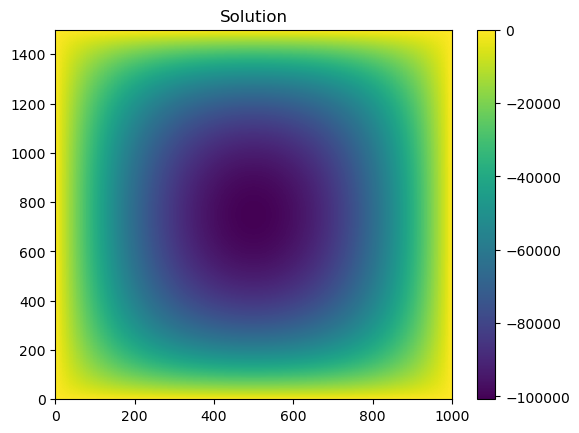

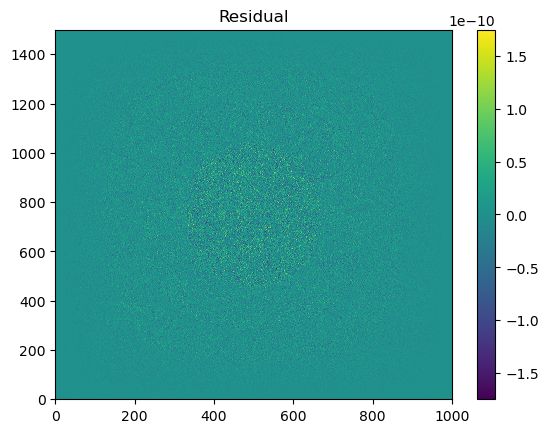

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [5]:
figure()
pcolor(grids[1].x,grids[1].y,grids[1].solution)
colorbar()
title("Solution")
show()
figure()
pcolor(grids[1].x,grids[1].y,grids[1].residual)
colorbar()
title("Residual")
show()